Initial imports 

In [1]:
import BiomarkerDiseaseRelation_Extraction, BiomarkerMatcher
import re

import cPickle, os, sys, matplotlib

sys.path.insert(1, os.path.join(sys.path[0], '..'))
%load_ext autoreload
%autoreload 2

from snorkel.snorkel import *
from snorkel.snorkel.snorkel import *
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)
filename = "articles/"
import unicodedata

Load in the Relations that have been generated in Candidate Extraction

In [2]:
# parser = DocParser(filename)
# sentences =parser.parseDocSentences()

R = BiomarkerDiseaseRelation_Extraction.generateRelations(_filename= filename)
# with open("articles.relations", "w+") as f:
#     cPickle.dump(Relations, f)
print R

/home/varun/Documents/Marker-Reader
dir: articles/nihms604917.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/zlj4536.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/PNAS-1998-Belinsky-11891-6.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/nihms389631.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/cam40003-1136.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/6246.full.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/nihms356718.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/5882.full.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/nihms551731.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/nihms143901.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/pone.0106748.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/nihms-489269.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/JO2012-709049.pdf.txt
/home/varun/Documents/Marker-Reader
dir: articles/1-s2.0-S0003267010012109-ma

KeyboardInterrupt: 

Generate features

In [2]:
# feats = None
# with open("articles.relations" , "w+") as f:
#     cPickle.dump(R, f)
print os.getcwd()
with open("articles.relations", "rb") as f:
    R = cPickle.load(f)
print type(R)
# relationsFile = "cache/" + filename + "/relations.pkl"
# if not os.path.exists("cache/" + filename +"/" ):
#     os.makedirs("cache/" + filename + "/")
# try:
#     with open(relationsFile, 'rb') as f:
#         feats = cPickle.load(f)
# except:
#     %time Relations.extract_features()
#     with open(relationsFile, 'w+') as f:
#         cPickle.dump(Relations.feats, f)
# feats = Relations.extract_features()
# R.extract_features()
print os.getcwd()
with open("articles.feats", "rb") as f:
    feats = cPickle.load(f)
DDL = DDLiteModel(R, feats)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

/home/varun/Documents/Marker-Reader
<class 'snorkel.snorkel.snorkel.Relations'>
/home/varun/Documents/Marker-Reader
Extracted 54735 features for each of 2633 mentions


Now load in the ground truth

In [3]:
# with open("articles.feats", "w+") as f:
#     cPickle.dump(R.feats, f)
print os.getcwd()
tuples = []
list = re.split("[^\\S ]", open("tags/tags8.tsv").read())
# print list
count = 7
while count < len(list):
    number = 0
    if (list[count + 6] == "true"):
        number = 1
    elif (list[count + 6] == "false"):
        number = -1
    tuples.append((list[count + 5] + "::" + list[count + 3] + "::[" + list[count + 4] + ", " + list[count] + "]::['" +
                 list[count + 1] + "', '" + list[count + 2] + "']", number))
    count += 7
gt = []
uids = []
for tuple in tuples:
    uids.append(tuple[0])
    gt.append(tuple[1])


# # with open('examples/gene_tag_example/gt/uids.pkl', 'rb') as f:
# #     uids2 = cPickle.load(f)
# # with open('examples/gene_tag_example/gt/gt.pkl', 'rb') as f:
# #     gt2 = cPickle.load(f)
    
# # print "UIDS \n"
# # print uids
# # print type(uids)
# # print "\n"
# # print "UIDS2 \n"
# # print uids2
# # print type(uids2)
# # print "\n"
# # print "GT \n"
# # print gt
# # print type(gt)
# # print "\n"
# # print "GT2 \n"
# # print gt2
# # print type(gt2)
# # print "\n"
DDL.update_gt(gt = gt[:50], uids = uids[:50])
DDL.set_holdout(validation_frac=0.5)

/home/varun/Documents/Marker-Reader


Launch mindtagger

In [4]:
DDL.open_mindtagger(num_sample=200, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


After mindtagger add the tags to the model?

In [5]:
DDL.add_mindtagger_tags()
DDL.update_gt(gt=gt[50:], uids=uids[50:])

Now load in the labelling functions

In [6]:
keyWords = ["associate", "express", "marker", "biomarker", "elevated", "decreased",
            "correlation", "correlates", "found", "diagnose", "variant", "appear",
            "connect", "relate", "exhibit", "indicate", "signify", "show", "demonstrate",
            "reveal", "suggest", "evidence", "elevation", "indication", "diagnosis",
            "variation", "modification", "suggestion", "link", "derivation", "denote",
            "denotation", "demonstration", "magnification", "depression", "boost", "level",
            "advance", "augmentation", "lessening", "enhancement", "expression", "buildup",
            "diminishing", "diminishment", "reduction", "drop", "dwindling", "lowering"]
negationWords = ["not", "nor", "neither"]

def presenceOfNot(m):
    for word in negationWords:
        if (word in m.post_window1('lemmas', 20)) and (word in m.pre_window2('lemmas', 20)):
            return True
    return False
"""ADD A LABELLING FUNCTION THAT GIVES A PLUS POINT FOR BEING IN THE DATABASE"""
# 1
def LF_remove_same_word(m):
    if(m.mention1(attribute='words')[0] == m.mention2(attribute='words')[0]):
        return -1
def LF_distance(m):
    print "FIRST"
    print type(m)
    # if 'neuroendocrine' in m.lemmas:
    #     print m.lemmas
    # print m.dep_labels
    distance = abs(m.e2_idxs[0] - m.e1_idxs[0])
    count = 0
    for lemma in m.lemmas:
        if lemma == ',':
            count += 1
    if count > 1 and ',' in m.pre_window1('lemmas', 1):
        print m
        return 0
    if distance == 0:
        return -1
    if distance < 8:
        # print "RETURNING ONE"
        return 0
    else:
        return -1
def LF_roman_numeral(m):
    biomarker = (m.mention1(attribute='words')[0])
    unicodedata.normalize('NFKD', biomarker).encode('ascii','ignore')
    if re.match(r'((?<=\s)|(?<=^))(M{1,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{1,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{1,3})(IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{1,3}))(?=\s)',
                biomarker):
        print "MATCHED ROMAN"
        print m.mention1(attribute='words')
        return -1
               
        
# def LF_keyword(m):
#         for word in keyWords:
#             if (word in m.post_window1('lemmas', 20)) and (word in m.pre_window2('lemmas', 20)):
#                 if presenceOfNot(m):
#                     return -1
#                 else:
#                     return 1
    
#     return 0

# def LF_associate(m):
#     if ('associate' in m.post_window1('lemmas', 20)) and ('associate' in m.pre_window2('lemmas', 20)):
#         return 1
#     else:
#         return 0
# # 3
# def LF_express(m):
#     return 1 if ('express' in m.post_window1('lemmas', 20)) and ('express' in m.pre_window2('lemmas', 20)) else 0
# # 4
def LF_marker(m):
    return 1 if (('marker' in m.post_window1('lemmas', 6) or 'biomarker' in m.post_window1('lemmas', 6)) and (
        'marker' in m.pre_window2('lemmas', 6) or 'biomarker' in m.pre_window2('lemmas', 6))) or (('marker' in m.pre_window1('lemmas', 6) or 'biomarker' in m.pre_window1('lemmas', 6)) and (
        'marker' in m.post_window2('lemmas', 6) or 'biomarker' in m.post_window2('lemmas', 6)))  else 0
# # 5
# def LF_elevated(m):
#     return 1 if ('elevated' in m.post_window1('lemmas', 20)) and ('elevated' in m.pre_window2('lemmas', 20)) else 0
# def LF_decreased(m):
#     return 1 if ('decreased' in m.post_window1('lemmas', 20)) and ('decreased' in m.pre_window2('lemmas', 20)) else 0
# # 6
# def LF_correlation(m):
#     return 1 if ('correlation' in m.pre_window1('lemmas', 20)) else 0
# # 7
# def LF_correlate(m):
#     return 1 if ('correlates' in m.post_window1('lemmas', 20)) and ('found' in m.pre_window2('lemmas', 20)) else 0
# # 8
# def LF_found(m):
#     return 1 if ('found' in m.post_window1('lemmas', 20)) and ('found' in m.pre_window2('lemmas', 20)) else 0
# 9 (-1 if biomarker is confused with a name of a person)
def LF_People(m):
    return -1 if ('NNP' in m.mention1(attribute='poses')) else 0

# #10
# def LF_diagnosed(m):
#     return 1 if('diagnose' in m.post_window1('lemmas', 20)) else 0
# #11
# def LF_variant(m):
#     return 1 if('variant of' in m.pre_window1('lemmas', 20)) else 0
# #12
# def LF_appear(m):
#     return 1 if ('appear' in m.post_window1('lemmas', 20)) else 0
# #13
# def LF_connect(m):
#     return 1 if ('connect' in m.post_window1('lemmas', 20)) else 0
# #14
# def LF_relate(m):
#     return 1 if ('relate' in m.post_window1('lemmas', 20)) else 0
# #15
# def LF_exhibit(m):
#     return 1 if ('exhibit' in m.post_window1('lemmas', 20)) else 0
# #16
# def LF_indicate(m):
#     return 1 if ('indicate' in m.post_window1('lemmas', 20)) else 0
# #17
# def LF_signify(m):
#     return 1 if ('signify' in m.post_window1('lemmas', 20)) else 0
# #18
# def LF_show(m):
#     return 1 if ('show' in m.post_window1('lemmas', 20)) else 0
# #19
# def LF_demonstrate(m):
#     return 1 if ('demonstrate' in m.post_window1('lemmas', 20)) else 0
# #20
# def LF_reveal(m):
#     return 1 if ('reveal' in m.post_window1('lemmas', 20)) else 0
# #21
# def LF_suggest(m):
#     return 1 if ('suggest' in m.post_window1('lemmas', 20)) else 0
# #22
# def LF_evidence(m):
#     return 1 if ('evidence for' in m.post_window1('lemmas', 20)) else 0
# #23
# def LF_indication(m):
#     return 1 if ('indication of' in m.post_window1('lemmas', 20)) else 0
# #24
# def LF_elevation(m):
#     return 1 if ('elevation' in m.post_window1('lemmas', 20)) else 0
# #25
# def LF_diagnosis(m):
#     return 1 if ('diagnosis of' in m.post_window1('lemmas', 20)) else 0
# #26
# def LF_variation(m):
#     return 1 if ('variation of' in m.pre_window1('lemmas', 20)) else 0
# #27
# def LF_modification(m):
#     return 1 if ('modification of' in m.pre_window1('lemmas', 20)) else 0
# #28
# def LF_suggestion(m):
#     return 1 if ('suggestion' in m.post_window1('lemmas', 20)) else 0
#
# # 29
# def LF_link(m):
#     return 1 if ('link' in m.post_window1('lemmas', 20)) else 0
#
# # 30
# def LF_derivation(m):
#     return 1 if ('derivation of' in m.pre_window1('lemmas', 20)) else 0
#
# # 31
# def LF_denote(m):
#     return 1 if ('denote' in m.post_window1('lemmas', 20)) else 0
#
# # 32
# def LF_denotation(m):
#     return 1 if ('denotation' in m.post_window1('lemmas', 20)) else 0
#
# # 33
# def LF_demonstration(m):
#     return 1 if ('demonstration' in m.post_window1('lemmas', 20)) else 0
#
# # 34
# def LF_magnification(m):
#     return 1 if ('magnification' in m.pre_window1('lemmas', 20)) else 0
#
# # 35
# def LF_depression(m):
#     return 1 if ('depression' in m.pre_window1('lemmas', 20)) else 0
#
# # 36
# def LF_boost(m):
#     return 1 if ('boost' in m.pre_window1('lemmas', 20)) else 0
#
# # 37
# def LF_level(m):
#     return 1 if ('level' in m.pre_window1('lemmas', 20)) else 0
#
# # 38
# def LF_advance(m):
#     return 1 if ('advance' in m.pre_window1('lemmas', 20)) else 0
#
# # 39
# def LF_augmentation(m):
#     return 1 if ('augmentation' in m.pre_window1('lemmas', 20)) else 0
#
# # 40
# def LF_decline(m):
#     return 1 if ('decline' in m.pre_window1('lemmas', 20)) else 0
#
# # 41
# def LF_lessening(m):
#     return 1 if ('lessening' in m.pre_window1('lemmas', 20)) else 0
#
# # 42
# def LF_enhancement(m):
#     return 1 if ('enhancement' in m.pre_window1('lemmas', 20)) else 0
#
# # 43
# def LF_expression(m):
#     return 1 if ('expression' in m.post_window1('lemmas', 20)) else 0
#
# # 44
# def LF_buildup(m):
#     return 1 if ('buildup' in m.pre_window1('lemmas', 20)) else 0
#
# # 45
# def LF_diminishing(m):
#     return 1 if ('diminishing' in m.pre_window1('lemmas', 20)) else 0
#
# # 46
# def LF_diminishment(m):
#     return 1 if ('diminishment' in m.pre_window1('lemmas', 20)) else 0
#
# # 47
# def LF_reduction(m):
#     return 1 if ('reduction' in m.pre_window1('lemmas', 20)) else 0
#
# # 48
# def LF_drop(m):
#     return 1 if ('drop' in m.pre_window1('lemmas', 20)) else 0
#
# # 49
# def LF_dwindling(m):
#     return 1 if ('dwindling' in m.pre_window1('lemmas', 20)) else 0
#
# # 50
# def LF_lowering(m):
#     return 1 if ('lowering' in m.pre_window1('lemmas', 20)) else 0
# 51
def LF_possible(m):
    return -1 if ('possible' in m.pre_window1('lemmas', 20)) else 0

# 52
def LF_explore(m):
    return -1 if ('explore' in m.pre_window1('lemmas', 20)) else 0

# 53
def LF_key(m):
    # print m.pre_window1('lemmas', 20)
    return -1 if ('abbreviation' in m.pre_window1('lemmas', 20) or (
        'word' in m.pre_window1('lemmas', 20) and 'key' in m.pre_window1('lemmas', 20))) else 0

# 54
def LF_investigate(m):
    return -1 if ('investigate' in m.pre_window1('lemmas', 20)) else 0

# 55
def LF_yetToBeConfirmed(m):
    return -1 if ('yet' in m.post_window1('lemmas', 20) and 'to' in m.post_window1('lemmas', 20) and 'be' in m.post_window1(
        'lemmas', 20) and 'confirmed' in m.post_window1('lemmas', 20)) else 0

# 56
def LF_notAssociated(m):
    return -1 if ('not' in m.post_window1('lemmas', 20) and 'associated' in m.post_window2('lemmas', 20)) else 0

# 56
def LF_notRelated(m):
    return -1 if ('not' in m.post_window1('lemmas', 20) and 'related' in m.post_window2('lemmas', 20)) else 0

# 57
def LF_doesNotShow(m):
    return -1 if (
        'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'show' in m.post_window2(
            'lemmas', 20)) else 0

# 58
def LF_notLinked(m):
    return -1 if ('not' in m.post_window1('lemmas', 20) and 'linked' in m.post_window2('lemmas', 20)) else 0

# 59
def LF_notCorrelated(m):
    return -1 if ('not' in m.post_window1('lemmas', 20) and 'correlated' in m.post_window2('lemmas', 20)) else 0

# 60
def LF_disprove(m):
    return -1 if ('disprove' in m.post_window1('lemmas', 20)) else 0


# 62
def LF_doesNotSignify(m):
    return -1 if (
        'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'signify' in m.post_window(
            'lemmas', 20)) else 0

# 63
def LF_doesNotIndicate(m):
    print "SECOND"
    return -1 if (
        'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'indicate' in m.post_window(
            'lemmas', 20)) else 0

    # 64
def LF_doesNotImply(m):
    print "THIRD"
    return -1 if (
        'does' in m.post_window1('lemmas', 20) and 'not' in m.post_window1('lemmas', 20) and 'imply' in m.post_window(
            'lemmas', 20)) else 0

#65
def LF_studies(m):
    return 1 if (
        'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and'reported' in m.pre_window1(
            'lemmas', 20)) else 0

# 66
def LF_studies2(m):
    return 1 if (
        'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and 'disclosed' in m.pre_window1(
            'lemmas', 20)) else 0

#67
def LF_studies3(m):
    return 1 if (
        'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and'disclosed' in m.pre_window1('lemmas', 20)) else 0

# 68

def LF_studies4(m):
    return 1 if (
        'studies' in m.pre_window1('lemmas', 20) and 'have' in m.pre_window1('lemmas', 20) and 'expressed' in m.pre_window1(
            'lemmas', 20)) else 0

# 69
def LF_interesting(m):
    return 1 if (
        'is' in m.post_window1('lemmas', 20) and 'an' in m.post_window1('lemmas', 20) and 'interesting' in m.post_window1(
            'lemmas', 20) and 'target' in m.post_window1('lemmas', 20) and 'is' in m.pre_window2('lemmas', 20) and 'an' in
        m.pre_window2('lemmas', 20) and 'interesting' in m.pre_window2('lemmas', 20) and 'target' in m.pre_window2(
            'lemmas', 20)) else 0
# 70
def LF_discussion(m):
    return 1 if (
        'discussion' in m.pre_window1('lemmas', 20)) else 0

# 71
def LF_conclusion(m):

    if ('conclusion' in m.pre_window1('lemmas', 20) or 'conclusion' in m.pre_window2('lemmas', 20)):
        # print "FOUND"
        return 1
    else:
        return 0

# 72
def LF_recently(m):
    return 1 if (
        'recently' in m.pre_window1('lemmas', 20) or 'recently' in m.post_window1('lemmas', 20)) else 0
# 73
def LF_induced(m):
    return 1 if (
        'induced' in m.post_window1('lemmas', 20) and 'induced' in m.pre_window2('lemmas', 20)) else 0
#74
def LF_treatment(m):
    return 1 if (
        'treatment' in m.pre_window1('lemmas', 20) or 'treatment' in m.post_window1('lemmas', 20)) else 0
def LF_auxpass(m):
    if not ('auxpass' and 'aux') in (m.post_window1('dep_labels', 20) and m.pre_window2('dep_labels', 20)):
        return -1
    else:
        return 0
def LF_inbetween(m):
    # with open('diseaseDatabase.pickle', 'rb') as f:
    #     diseaseDictionary = pickle.load(f)
    # with open('diseaseAbbreviationsDatabase.pickle', 'rb') as f:
    #     diseaseAbb = pickle.load(f)
    # with open('markerData.pickle', 'rb') as f:
    #     markerDatabase = pickle.load(f)
    # for marker in markerDatabase:
    #     if(marker in list[m.e1_idxs[0] : m.e2_idxs[0]]):
    #         return -1
    # for disease in diseaseDictionary:
    #     if (disease in list[m.e1_idxs[0]: m.e2_idxs[0]]):
    #         return -1
    # for disease in diseaseAbb:
    #     if (marker in list[m.e1_idxs[0]: m.e2_idxs[0]]):
    #         return -1
    return 0
def LF_patientsWith(m):
    return 1 if ('patient' in m.post_window2('lemmas', 3)) and ('with' in m.post_window2('lemmas',2)) else 0

def LF_isaBiomarker(m):
    post_window1_lemmas = m.post_window1('lemmas',20)
    pre_window2_lemmas = m.pre_window2('lemmas',20)
    if ('biomarker' in post_window1_lemmas and 'biomarker' in pre_window2_lemmas) or ('marker' in post_window1_lemmas and 'marker' in pre_window2_lemmas) or ('indicator' in post_window1_lemmas and 'indicator' in pre_window2_lemmas):
        marker_idx_post_window1 = -1
        markers = ['biomarker','marker','indicator']
        for marker in markers:
            try:
                # print post_window1_lemmas
                findMarker = post_window1_lemmas.index(marker)
                if not findMarker == -1:
                    marker_idx_post_window1 = findMarker
                    print marker
            except:
                pass
        if 'cop' in m.post_window1('dep_labels',20):
            try:
                cop_idx_post_window1 = m.post_window1('dep_labels',20).index('cop')
            except:
                pass
            
            print "MarkerIdx:"
            print marker_idx_post_window1
            print "ROOTIdx:"
            try:
                print  m.post_window1('dep_labels',marker_idx_post_window1)
                print  m.post_window1('dep_labels',marker_idx_post_window1).index('ROOT')
            except:
                pass
            print '\n'
            
            return 1 if ('nsubj' in m.mention1(attribute='dep_labels')) and (marker_idx_post_window1-cop_idx_post_window1 < 4)  else 0
    return 0

def LF_suspect(m):
    return -1 if ('suspect' in m.pre_window1('lemmas', 20) or 'suspect' in m.post_window1('lemmas', 20)) else 0



def LF_mark(m):
    return -1 if ( 'vmod' in m.post_window1('dep_labels', 20) and 'mark' in m.post_window1('dep_labels', 20) or'vmod' in m.pre_window1('dep_labels', 20) and 'mark' in m.pre_window1('dep_labels', 20)) else 0

Now apply these LFs

In [7]:

LFs = [LF_investigate, LF_key,  LF_distance,  LF_auxpass, LF_inbetween,
       LF_possible, LF_explore, LF_key, LF_investigate, LF_yetToBeConfirmed, LF_notAssociated, LF_notRelated,
       LF_doesNotShow, LF_notLinked, LF_notCorrelated, LF_disprove, LF_doesNotSignify,
       LF_doesNotIndicate, LF_doesNotImply, LF_studies, LF_studies2, LF_studies3, LF_studies4, LF_interesting,
       LF_discussion, LF_conclusion, LF_recently, LF_induced, LF_treatment, LF_isaBiomarker, LF_marker, LF_suspect, LF_mark, LF_People]
DDL.apply_lfs(LFs, clear=False)

FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<class 'snorkel.snorkel.snorkel.Relation'>
SECOND
THIRD
FIRST
<c

You can add stats stuff here if you care:

In [8]:
DDL.lowest_empirical_accuracy_lfs(n=10)

100% accuracy and 0 generalization score are "perfect"


snorkel/snorkel/snorkel.py:569: UserWarning: Dev sets are too small for reliable estimates
  warnings.warn("Dev sets are too small for reliable estimates")


Labeling function,Positive accuracy,Gen. score
LF_isaBiomarker,0.00% (n=0),0.00 (n=0)
LF_discussion,0.00% (n=0),0.00 (n=0)
LF_treatment,0.00% (n=0),0.00 (n=0)
LF_recently,0.00% (n=0),0.00 (n=0)
LF_conclusion,0.00% (n=0),0.00 (n=0)
LF_marker,0.00% (n=0),0.00 (n=0)
Labeling function,Negative accuracy,Gen. score
LF_distance,0.00% (n=0),0.00 (n=1)
LF_auxpass,0.00% (n=0),0.00 (n=1)
LF_People,0.00% (n=0),0.00 (n=0)


Being learning

Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.506768
	Learning epoch = 250	Gradient mag. = 0.917828
Final gradient magnitude for rate=0.01, mu=1e-07: 1.161
Begin training for rate=0.01, mu=1e-09
	Learning epoch = 0	Gradient mag. = 0.078849
	Learning epoch = 250	Gradient mag. = 0.082777
	Learning epoch = 500	Gradient mag. = 0.082556
	Learning epoch = 750	Gradient mag. = 0.082337
	Learning epoch = 1000	Gradient mag. = 0.082120
	Learning epoch = 1250	Gradient mag. = 0.081904
	Learning epoch = 1500	Gradient mag. = 0.081690
	Learning epoch = 1750	Gradient mag. = 0.081477
	Learning epoch = 2000	Gradient mag. = 0.081266
	Learning epoch = 2250	Gradient mag. = 0.081056
	Learning epoch = 2500	Gradient mag. = 0.080847
	Learning epoch = 2750	Gradient mag. = 0.080640
Final gradient magnitude for rate=0.01, mu=1e-09: 0.080
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.078849
	Learning epoch = 250	Gradient mag. = 0.082777
	Learning epoch =

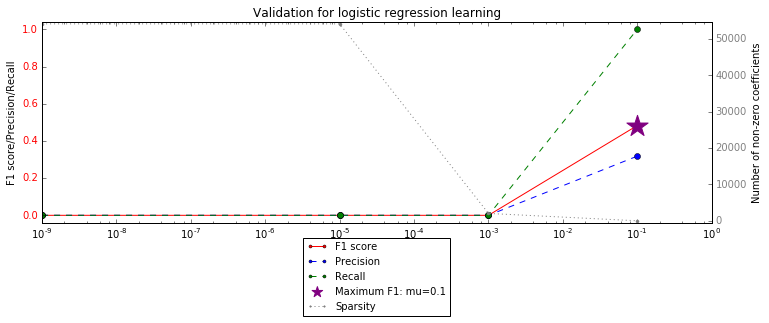

CPU times: user 42.9 s, sys: 1.04 s, total: 43.9 s
Wall time: 42.9 s


<snorkel.snorkel.snorkel.ModelLog instance at 0x7f5582b0fcf8>

In [9]:
matplotlib.rcParams['figure.figsize'] = (12,4)
mu_seq = np.ravel([1e-9, 1e-5, 1e-3, 1e-1])
lf_opts = {'sample': False, 'verbose': True}
model_opts = {'sample': False, 'n_iter': 3000, 'alpha': 0.5, 'mu': mu_seq, 'bias': False, 'verbose': True}
%time DDL.train_model(method='lr', lf_opts=lf_opts, model_opts=model_opts)

Calibration and Accuracy

In [ ]:
DDL.plot_calibration()

In [10]:
idxs, gt = DDL.get_labeled_ground_truth(subset=DDL.holdout())
acc_feats = np.mean(DDL.get_predicted(subset=DDL.holdout()) == gt)
acc_lfs = np.mean(DDL.get_lf_predicted(subset=DDL.holdout()) == gt)
print "LF accuracy: {:.3f}\nFull model accuracy: {:.3f}".format(acc_lfs, acc_feats)

LF accuracy: 0.727
Full model accuracy: 0.000


In [ ]:
DDL.print_lf_stats()

In [ ]:
DDL.plot_lf_stats()